In [1]:

# Bước 1: Chuẩn bị Môi trường và Cài đặt Thư viện

print(" Bước 1: Chuẩn bị Môi trường ")

import os
import shutil
import random
import yaml
import glob
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Cài đặt Ultralytics
!pip install ultralytics pandas matplotlib seaborn -q
from ultralytics import YOLO
from ultralytics.utils.metrics import ConfusionMatrix

# Cài đặt hiển thị cho Pandas
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Cài đặt thư viện và import hoàn tất.")


--- Bước 1: Chuẩn bị Môi trường ---
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.1 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but

In [3]:

# Bước 2: Chuẩn bị Dữ liệu

print("\n Bước 2: Chuẩn bị Dữ liệu ")

# --- 2.1: Định nghĩa đường dẫn và Tham số ---
# !!! THAY THẾ BẰNG TÊN DATASET CỦA BẠN TRÊN KAGGLE !!!
DATASET_NAME = 'insect-sticky-trap-dataset'
# Giả sử Dataset của bạn có thư mục images và annotations
BASE_INPUT_PATH = f'/kaggle/input/yellow-sticky-traps-dataset-main'
IMAGE_DIR_INPUT = os.path.join(BASE_INPUT_PATH, 'images')
ANNOTATION_DIR_INPUT = os.path.join(BASE_INPUT_PATH, 'annotations')

# Kiểm tra xem các thư mục input có tồn tại không
if not os.path.exists(IMAGE_DIR_INPUT):
    raise FileNotFoundError(f"Lỗi: Thư mục ảnh '{IMAGE_DIR_INPUT}' không tồn tại.")
if not os.path.exists(ANNOTATION_DIR_INPUT):
     raise FileNotFoundError(f"Lỗi: Thư mục annotation '{ANNOTATION_DIR_INPUT}' không tồn tại.")

print(f"Thư mục ảnh đầu vào: {IMAGE_DIR_INPUT}")
print(f"Thư mục annotation đầu vào: {ANNOTATION_DIR_INPUT}")

# Đường dẫn thư mục làm việc trong Kaggle
WORKING_DIR = '/kaggle/working/insect_dataset_yolo_standard'
os.makedirs(WORKING_DIR, exist_ok=True)
print(f"Thư mục làm việc: {WORKING_DIR}")

# Tạo thư mục tạm để lưu labels YOLO
TEMP_YOLO_LABEL_DIR = os.path.join(WORKING_DIR, 'temp_yolo_labels')
os.makedirs(TEMP_YOLO_LABEL_DIR, exist_ok=True)
print(f"Thư mục tạm lưu labels YOLO: {TEMP_YOLO_LABEL_DIR}")

# Định nghĩa lớp và mapping
CLASS_MAP = {'MR': 0, 'NC': 1, 'WF': 2}
CLASSES = list(CLASS_MAP.keys())
print(f"Các lớp côn trùng: {CLASSES}")
print(f"Mapping Lớp -> Index: {CLASS_MAP}")

# Random seed
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
print(f"Sử dụng Random Seed: {RANDOM_SEED}")


--- Bước 2: Chuẩn bị Dữ liệu ---
Thư mục ảnh đầu vào: /kaggle/input/yellow-sticky-traps-dataset-main/images
Thư mục annotation đầu vào: /kaggle/input/yellow-sticky-traps-dataset-main/annotations
Thư mục làm việc: /kaggle/working/insect_dataset_yolo_standard
Thư mục tạm lưu labels YOLO: /kaggle/working/insect_dataset_yolo_standard/temp_yolo_labels
Các lớp côn trùng: ['MR', 'NC', 'WF']
Mapping Lớp -> Index: {'MR': 0, 'NC': 1, 'WF': 2}
Sử dụng Random Seed: 42


In [4]:


# 2.2: Hàm Chuyển đổi Annotation (XML -> YOLO TXT) 
# Giả định size XML khớp size ảnh thực tế
def convert_xml_to_yolo(xml_file_path, img_width, img_height, output_dir, class_map, base_img_filename):
    """Chuyển đổi XML sang YOLO TXT, dùng img_width/height để chuẩn hóa."""
    try:
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
    except ET.ParseError:
        print(f"Lỗi parse XML: {xml_file_path}")
        return False

    yolo_lines = []
    objects_converted = 0
    objects_skipped = 0

    # Kiểm tra size trong XML (optional, vì đã giả định khớp)
    # size = root.find('size')
    # xml_width = int(size.find('width').text)
    # xml_height = int(size.find('height').text)
    # if xml_width != img_width or xml_height != img_height:
    #      print(f"  Cảnh báo: Size XML ({xml_width}x{xml_height}) không khớp size ảnh ({img_width}x{img_height}) cho {base_img_filename}!")
         # Có thể dừng hoặc tiếp tục tùy theo mức độ tin cậy giả định

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_map:
            objects_skipped += 1
            continue

        class_index = class_map[class_name]
        bndbox = obj.find('bndbox')
        try:
            xmin = float(bndbox.find('xmin').text)
            ymin = float(bndbox.find('ymin').text)
            xmax = float(bndbox.find('xmax').text)
            ymax = float(bndbox.find('ymax').text)
        except (AttributeError, ValueError, TypeError) as e:
            print(f"  Lỗi đọc bbox cho {class_name} trong {base_img_filename}.xml: {e}. Bỏ qua.")
            objects_skipped += 1
            continue

        # Kẹp tọa độ vào biên ảnh
        final_xmin = max(0.0, xmin)
        final_ymin = max(0.0, ymin)
        final_xmax = min(img_width, xmax)
        final_ymax = min(img_height, ymax)

        # Kiểm tra lại sau khi kẹp
        if final_xmin >= final_xmax or final_ymin >= final_ymax:
            # print(f"  Cảnh báo: Bbox cho {class_name} trong {base_img_filename}.xml không hợp lệ sau khi kẹp. Bỏ qua.")
            objects_skipped += 1
            continue

        # Chuẩn hóa bằng kích thước ảnh thực tế
        x_center = ((final_xmin + final_xmax) / 2) / img_width
        y_center = ((final_ymin + final_ymax) / 2) / img_height
        width = (final_xmax - final_xmin) / img_width
        height = (final_ymax - final_ymin) / img_height

        # Kẹp giá trị chuẩn hóa [0, 1]
        x_center = max(0.0, min(1.0, x_center))
        y_center = max(0.0, min(1.0, y_center))
        width = max(0.0, min(1.0, width))
        height = max(0.0, min(1.0, height))

        if width > 0 and height > 0:
             yolo_lines.append(f"{class_index} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
             objects_converted += 1
        else:
            objects_skipped += 1
            continue

    if not yolo_lines:
        # print(f"DEBUG: Convert - Không tạo được dòng YOLO hợp lệ cho {base_img_filename}.xml (Skipped: {objects_skipped})")
        pass

    if yolo_lines:
        output_txt_path = os.path.join(output_dir, f"{base_img_filename}.txt")
        try:
            with open(output_txt_path, 'w') as f:
                f.write("\n".join(yolo_lines))
            return True
        except IOError as e:
             print(f"Lỗi ghi file label: {output_txt_path}: {e}")
             return False
    return False

In [5]:
#  2.3: Vòng lặp Xử lý và Tạo Labels
print("\nBắt đầu xử lý ảnh và chuyển đổi annotation...")

all_image_paths = sorted(glob.glob(os.path.join(IMAGE_DIR_INPUT, '*.jpg')) + \
                         glob.glob(os.path.join(IMAGE_DIR_INPUT, '*.png')) + \
                         glob.glob(os.path.join(IMAGE_DIR_INPUT, '*.jpeg')))

print(f"Tìm thấy {len(all_image_paths)} file ảnh trong {IMAGE_DIR_INPUT}.")

processed_image_paths = [] # Lưu đường dẫn ảnh gốc đã xử lý thành công
label_generation_success_count = 0
processing_fail_count = 0

for img_path in all_image_paths:
    img_filename_no_ext = os.path.splitext(os.path.basename(img_path))[0]
    xml_filename = f"{img_filename_no_ext}.xml"
    xml_path = os.path.join(ANNOTATION_DIR_INPUT, xml_filename)

    if os.path.exists(xml_path):
        try:
            # Đọc ảnh để lấy kích thước thực tế
            img = cv2.imread(img_path)
            if img is None:
                print(f"  Lỗi đọc ảnh: {img_path}. Bỏ qua.")
                processing_fail_count += 1
                continue
            img_height, img_width, _ = img.shape

            # Chuyển đổi annotation
            label_success = convert_xml_to_yolo(xml_path, img_width, img_height, TEMP_YOLO_LABEL_DIR, CLASS_MAP, img_filename_no_ext)

            if label_success:
                processed_image_paths.append(img_path) # Lưu đường dẫn ảnh gốc
                label_generation_success_count += 1
            else:
                processing_fail_count += 1
        except Exception as e:
            print(f"  Lỗi không xác định khi xử lý {img_filename_no_ext}: {e}")
            processing_fail_count += 1
    else:
        # print(f"  Cảnh báo: Không tìm thấy XML tương ứng ({xml_filename}) cho ảnh: {img_filename_no_ext}")
        processing_fail_count += 1
        pass

print(f"\nHoàn tất xử lý.")
print(f" -> Số cặp ảnh/label xử lý thành công: {label_generation_success_count}")
print(f" -> Số file bị bỏ qua/thất bại: {processing_fail_count}")
print(f" -> Tổng số label trong thư mục tạm '{TEMP_YOLO_LABEL_DIR}': {len(glob.glob(os.path.join(TEMP_YOLO_LABEL_DIR, '*.txt')))}")


Bắt đầu xử lý ảnh và chuyển đổi annotation...
Tìm thấy 284 file ảnh trong /kaggle/input/yellow-sticky-traps-dataset-main/images.

Hoàn tất xử lý.
 -> Số cặp ảnh/label xử lý thành công: 284
 -> Số file bị bỏ qua/thất bại: 0
 -> Tổng số label trong thư mục tạm '/kaggle/working/insect_dataset_yolo_standard/temp_yolo_labels': 284


In [6]:
# 2.4: DEBUGGING - Kiểm tra khớp nối ảnh và label tạm
print("\n DEBUGGING kiểm tra file tạm ")
actual_label_files = glob.glob(os.path.join(TEMP_YOLO_LABEL_DIR, '*.txt'))
# Lấy tên file cơ sở từ ảnh đã xử lý thành công
processed_img_basenames = set(os.path.splitext(os.path.basename(p))[0] for p in processed_image_paths)
actual_label_basenames = set(os.path.splitext(os.path.basename(l))[0] for l in actual_label_files)

missing_labels = processed_img_basenames - actual_label_basenames
extra_labels = actual_label_basenames - processed_img_basenames
matching_basenames = processed_img_basenames.intersection(actual_label_basenames)

print(f" -> Tên file cơ sở từ ảnh xử lý: {len(processed_img_basenames)}")
print(f" -> Tên file cơ sở từ label .txt: {len(actual_label_basenames)}")
print(f" -> Số tên file KHỚP: {len(matching_basenames)}")

if missing_labels: print(f"CẢNH BÁO: {len(missing_labels)} ảnh xử lý nhưng KHÔNG có label .txt! Ví dụ:", list(missing_labels)[:5])
if extra_labels: print(f"CẢNH BÁO: {len(extra_labels)} label .txt thừa! Ví dụ:", list(extra_labels)[:5])

# Chỉ sử dụng những file có cả ảnh gốc và label .txt tương ứng
valid_image_paths = []
original_image_map = {os.path.splitext(os.path.basename(p))[0]: p for p in processed_image_paths}
for basename in matching_basenames:
    if basename in original_image_map:
         valid_image_paths.append(original_image_map[basename])

print(f"\nSố lượng ảnh cuối cùng hợp lệ để chia: {len(valid_image_paths)}")
print("--- Kết thúc DEBUGGING ---")



 DEBUGGING kiểm tra file tạm 
 -> Tên file cơ sở từ ảnh xử lý: 284
 -> Tên file cơ sở từ label .txt: 284
 -> Số tên file KHỚP: 284

Số lượng ảnh cuối cùng hợp lệ để chia: 284
--- Kết thúc DEBUGGING ---


In [7]:
# 2.5: Chia Dữ liệu (Train/Validation)
print("\nBắt đầu chia dữ liệu thành tập Train và Validation")

if not valid_image_paths:
    raise ValueError("Lỗi: Không có ảnh hợp lệ nào để chia dữ liệu.")
else:
    valid_filenames = [os.path.splitext(os.path.basename(p))[0] for p in valid_image_paths]

    train_filenames, val_filenames = train_test_split(
        valid_filenames,
        test_size=0.2, # 80% train, 20% val
        random_state=RANDOM_SEED # Đảm bảo chia giống nhau mỗi lần chạy
    )
    print(f"Số lượng file trong tập Train: {len(train_filenames)}")
    print(f"Số lượng file trong tập Validation: {len(val_filenames)}")

    # Tạo cấu trúc thư mục YOLO cuối cùng
    final_train_img_dir = os.path.join(WORKING_DIR, 'images', 'train')
    final_val_img_dir = os.path.join(WORKING_DIR, 'images', 'val')
    final_train_label_dir = os.path.join(WORKING_DIR, 'labels', 'train')
    final_val_label_dir = os.path.join(WORKING_DIR, 'labels', 'val')
    os.makedirs(final_train_img_dir, exist_ok=True)
    os.makedirs(final_val_img_dir, exist_ok=True)
    os.makedirs(final_train_label_dir, exist_ok=True)
    os.makedirs(final_val_label_dir, exist_ok=True)
    print("Đã tạo cấu trúc thư mục cuối cùng cho train/val.")

    # Hàm copy file an toàn
    def safe_copy(src, dst):
        try:
            shutil.copy2(src, dst)
            return True
        except Exception as e:
            print(f"Lỗi copy {src} -> {dst}: {e}")
            return False

    # Hàm copy dữ liệu từ nguồn gốc/tạm sang thư mục cuối cùng
    def copy_final_split(filenames, source_valid_img_paths_list, source_temp_label_dir, dest_final_img_dir, dest_final_label_dir):
        copied_count = 0
        # Map từ tên file gốc -> đường dẫn ảnh GỐC hợp lệ
        source_img_map = {os.path.splitext(os.path.basename(p))[0]: p for p in source_valid_img_paths_list}
        print(f"  -> Bắt đầu copy {len(filenames)} file...")
        files_failed = []
        for fname in filenames:
            src_img_path = source_img_map.get(fname) # Đường dẫn ảnh GỐC
            src_temp_label_path = os.path.join(source_temp_label_dir, f"{fname}.txt") # Đường dẫn label trong TEMP

            if src_img_path and os.path.exists(src_temp_label_path) and os.path.exists(src_img_path):
                img_basename = os.path.basename(src_img_path) # Tên file ảnh gốc
                dest_final_img_path = os.path.join(dest_final_img_dir, img_basename)
                dest_final_label_path = os.path.join(dest_final_label_dir, f"{fname}.txt") # Label luôn dùng tên gốc

                img_copied = safe_copy(src_img_path, dest_final_img_path) # Copy ảnh GỐC
                label_copied = safe_copy(src_temp_label_path, dest_final_label_path) # Copy label TẠM
                if img_copied and label_copied:
                    copied_count += 1
                else:
                    files_failed.append(fname)
                    if os.path.exists(dest_final_img_path): os.remove(dest_final_img_path)
                    if os.path.exists(dest_final_label_path): os.remove(dest_final_label_path)
            else:
                print(f"    Cảnh báo: Thiếu file nguồn gốc/tạm cho '{fname}' khi copy final!")
                files_failed.append(fname)
        if files_failed: print(f"  -> Cảnh báo: {len(files_failed)} file không copy được.")
        print(f"  -> Kết thúc copy final. Thành công: {copied_count}")
        return copied_count

    # Thực hiện copy vào thư mục cuối cùng
    print("\nBắt đầu sao chép file vào thư mục Train cuối cùng...")
    train_copied = copy_final_split(train_filenames, valid_image_paths, TEMP_YOLO_LABEL_DIR, final_train_img_dir, final_train_label_dir)
    print("\nBắt đầu sao chép file vào thư mục Validation cuối cùng...")
    val_copied = copy_final_split(val_filenames, valid_image_paths, TEMP_YOLO_LABEL_DIR, final_val_img_dir, final_val_label_dir)

    # Kiểm tra lại số lượng file cuối cùng
    final_train_imgs_count = len(glob.glob(os.path.join(final_train_img_dir, '*')))
    final_train_lbls_count = len(glob.glob(os.path.join(final_train_label_dir, '*.txt')))
    final_val_imgs_count = len(glob.glob(os.path.join(final_val_img_dir, '*')))
    final_val_lbls_count = len(glob.glob(os.path.join(final_val_label_dir, '*.txt')))
    print(f"\nKiểm tra thư mục cuối cùng:")
    print(f" -> Train images: {final_train_imgs_count}, Train labels: {final_train_lbls_count}")
    print(f" -> Val images: {final_val_imgs_count}, Val labels: {final_val_lbls_count}")
    if final_train_imgs_count != train_copied or final_val_imgs_count != val_copied or final_train_imgs_count != final_train_lbls_count or final_val_imgs_count != final_val_lbls_count:
        print("!!! CẢNH BÁO: Số lượng file cuối cùng không khớp !!!")
    print("\nHoàn tất việc chia và sao chép dữ liệu.")


Bắt đầu chia dữ liệu thành tập Train và Validation
Số lượng file trong tập Train: 227
Số lượng file trong tập Validation: 57
Đã tạo cấu trúc thư mục cuối cùng cho train/val.

Bắt đầu sao chép file vào thư mục Train cuối cùng...
  -> Bắt đầu copy 227 file...
  -> Kết thúc copy final. Thành công: 227

Bắt đầu sao chép file vào thư mục Validation cuối cùng...
  -> Bắt đầu copy 57 file...
  -> Kết thúc copy final. Thành công: 57

Kiểm tra thư mục cuối cùng:
 -> Train images: 227, Train labels: 227
 -> Val images: 57, Val labels: 57

Hoàn tất việc chia và sao chép dữ liệu.


In [8]:
#  2.6: Tạo File Cấu hình Dataset (`data.yaml`) 
print("\nTạo file cấu hình dataset (data.yaml)...")
dataset_yaml_content = f"""
train: {final_train_img_dir} # Trỏ đến thư mục ảnh train cuối cùng
val: {final_val_img_dir}   # Trỏ đến thư mục ảnh val cuối cùng

nc: {len(CLASSES)}
names: {CLASSES}
"""
yaml_file_path = os.path.join(WORKING_DIR, 'insect_data_standard.yaml')
try:
    with open(yaml_file_path, 'w') as f:
        f.write(dataset_yaml_content)
    print(f"File data YAML đã được tạo tại: {yaml_file_path}")
    print("\nNội dung file YAML:")
    print(dataset_yaml_content)
except Exception as e:
    print(f"Lỗi khi tạo file YAML: {e}")
    raise



Tạo file cấu hình dataset (data.yaml)...
File data YAML đã được tạo tại: /kaggle/working/insect_dataset_yolo_standard/insect_data_standard.yaml

Nội dung file YAML:

train: /kaggle/working/insect_dataset_yolo_standard/images/train # Trỏ đến thư mục ảnh train cuối cùng
val: /kaggle/working/insect_dataset_yolo_standard/images/val   # Trỏ đến thư mục ảnh val cuối cùng

nc: 3
names: ['MR', 'NC', 'WF']



In [9]:

# Bước 3: Huấn luyện Mô hình YOLOv8

print("\n Bước 3: Huấn luyện Mô hình YOLOv8")

MODEL_NAME = 'yolov8s.pt'
EPOCHS = 150
IMG_SIZE = 640 
BATCH_SIZE = 16
PATIENCE = 25
PROJECT_NAME = 'insect_detection_runs_standard' 
RUN_NAME = f'yolov8s_std_e{EPOCHS}_img{IMG_SIZE}_b{BATCH_SIZE}' 

print(f"Model: {MODEL_NAME}, Epochs: {EPOCHS}, ImgSize: {IMG_SIZE}, Batch: {BATCH_SIZE}, Patience: {PATIENCE}")
print(f"Kết quả lưu tại: {PROJECT_NAME}/{RUN_NAME}")

print("\nBắt đầu quá trình huấn luyện...")
TRAIN_OUTPUT_DIR = None
BEST_MODEL_PATH = None
try:
    model = YOLO(MODEL_NAME)
    results = model.train(
        data=yaml_file_path, # Dùng file YAML mới
        epochs=EPOCHS,
        imgsz=IMG_SIZE,
        batch=BATCH_SIZE,
        patience=PATIENCE,
        project=PROJECT_NAME,
        name=RUN_NAME,
        device=0,
        exist_ok=True,
        seed=RANDOM_SEED # Seed cho training
    )
    print("\nHoàn tất quá trình huấn luyện.")
    TRAIN_OUTPUT_DIR = os.path.join('/kaggle/working', PROJECT_NAME, RUN_NAME)
    BEST_MODEL_PATH = os.path.join(TRAIN_OUTPUT_DIR, 'weights', 'best.pt')
    if not os.path.exists(BEST_MODEL_PATH): BEST_MODEL_PATH = None
    if BEST_MODEL_PATH: print(f"Trọng số tốt nhất: {BEST_MODEL_PATH}")
    else: print("Cảnh báo: Không tìm thấy best.pt")
except Exception as e:
    print(f"\nLỗi huấn luyện: {e}")
    TRAIN_OUTPUT_DIR = os.path.join('/kaggle/working', PROJECT_NAME, RUN_NAME)
    if not os.path.exists(TRAIN_OUTPUT_DIR): TRAIN_OUTPUT_DIR = None
    BEST_MODEL_PATH = None


 Bước 3: Huấn luyện Mô hình YOLOv8
Model: yolov8s.pt, Epochs: 150, ImgSize: 640, Batch: 16, Patience: 25
Kết quả lưu tại: insect_detection_runs_standard/yolov8s_std_e150_img640_b16

Bắt đầu quá trình huấn luyện...


100%|██████████| 21.5M/21.5M [00:00<00:00, 166MB/s]


Ultralytics 8.3.132 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/insect_dataset_yolo_standard/insect_data_standard.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_std_e150_img640_b16, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pat

100%|██████████| 755k/755k [00:00<00:00, 17.4MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2675.0±1770.6 MB/s, size: 3294.1 KB)


train: Scanning /kaggle/working/insect_dataset_yolo_standard/labels/train... 227 images, 0 backgrounds, 0 corrupt: 100%|██████████| 227/227 [00:00<00:00, 958.16it/s]

train: New cache created: /kaggle/working/insect_dataset_yolo_standard/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1156.1±1268.8 MB/s, size: 3835.6 KB)


val: Scanning /kaggle/working/insect_dataset_yolo_standard/labels/val... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<00:00, 390.98it/s]

val: New cache created: /kaggle/working/insect_dataset_yolo_standard/labels/val.cache


Plotting labels to insect_detection_runs_standard/yolov8s_std_e150_img640_b16/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to insect_detection_runs_standard/yolov8s_std_e150_img640_b16
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      5.61G      3.044      4.757      1.111         93        640: 100%|██████████| 15/15 [00:20<00:00,  1.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.20s/it]

                   all         57       1890      0.325      0.302      0.233     0.0671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      6.88G      2.478      2.077      0.972        136        640: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         57       1890       0.33      0.306      0.221     0.0675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      6.89G      2.349      1.824     0.9456        216        640: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         57       1890      0.443      0.554        0.4      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      6.89G      2.348      1.661     0.9328        176        640: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         57       1890      0.464       0.63      0.527      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      6.89G      2.342      1.483     0.9333        251        640: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         57       1890      0.493      0.631      0.454      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      6.89G      2.307      1.397     0.9346         88        640: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         57       1890      0.439      0.558      0.378      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      6.89G      2.241      1.331     0.9374        112        640: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         57       1890      0.644      0.599      0.603      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      6.89G      2.195      1.256     0.9162        136        640: 100%|██████████| 15/15 [00:09<00:00,  1.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         57       1890      0.773      0.624      0.679      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      6.89G      2.211      1.208     0.9174        154        640: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         57       1890      0.675      0.686      0.714      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      6.89G      2.178      1.166     0.9244        119        640: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         57       1890      0.661      0.594      0.644      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      6.89G      2.142      1.129     0.9151         51        640: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         57       1890      0.645      0.641      0.642      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      6.89G      2.145      1.159     0.9178         73        640: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         57       1890      0.737      0.692      0.745      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      6.89G      2.121      1.142     0.9144        198        640: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         57       1890      0.656      0.601      0.641      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      6.89G      2.123      1.206     0.9097         80        640: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         57       1890      0.652      0.595      0.695      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      6.89G      2.138      1.139     0.9006        178        640: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         57       1890      0.757      0.615      0.705      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      6.89G      2.127       1.12     0.9045        121        640: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         57       1890      0.675      0.674      0.644      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      6.89G      2.152      1.122     0.9065        124        640: 100%|██████████| 15/15 [00:09<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         57       1890      0.605      0.642      0.545      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      6.89G      2.075      1.103     0.9014         53        640: 100%|██████████| 15/15 [00:09<00:00,  1.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         57       1890      0.679      0.726      0.676      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      6.89G      2.131      1.105     0.9092        175        640: 100%|██████████| 15/15 [00:11<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         57       1890      0.756      0.711      0.754      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      6.89G       2.07      1.097     0.9085         97        640: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         57       1890       0.76      0.704      0.727      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      6.89G      2.081      1.088     0.9062         83        640: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         57       1890      0.744      0.694      0.761      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      6.89G       2.09      1.104     0.9025         50        640: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         57       1890       0.81      0.719      0.803      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      6.89G      2.075      1.093     0.8986        120        640: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         57       1890       0.66      0.688      0.666      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      6.89G      2.036      1.047     0.9069         68        640: 100%|██████████| 15/15 [00:08<00:00,  1.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         57       1890       0.84      0.715      0.804      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      6.89G       2.05      1.103      0.892        117        640: 100%|██████████| 15/15 [00:08<00:00,  1.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         57       1890      0.732      0.701       0.76       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      6.89G      2.112      1.082     0.9084        115        640: 100%|██████████| 15/15 [00:09<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         57       1890      0.792      0.714      0.781      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      6.89G      2.019      1.072     0.8958        100        640: 100%|██████████| 15/15 [00:10<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         57       1890      0.716        0.7      0.759       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      6.89G       2.01      1.032     0.9037         92        640: 100%|██████████| 15/15 [00:08<00:00,  1.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         57       1890      0.743      0.707      0.761      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      6.89G      2.094      1.065     0.8859        253        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         57       1890      0.663      0.681      0.763      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      6.89G          2      1.038     0.8892         96        640: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         57       1890      0.761      0.692      0.745      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      6.89G      1.992       1.04     0.8992         75        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         57       1890      0.786      0.747      0.789      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      6.89G      2.087      1.081     0.8886        140        640: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         57       1890      0.793       0.71      0.783       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      6.89G      2.091      1.054        0.9        234        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         57       1890      0.802      0.716       0.79      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      7.74G      2.027      1.021     0.9002         82        640: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         57       1890      0.769      0.699       0.77      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      4.95G      2.037      1.015     0.8986        119        640: 100%|██████████| 15/15 [00:09<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         57       1890       0.74      0.716      0.764      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      6.38G      2.003      1.009     0.9003        111        640: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         57       1890      0.796       0.71      0.779      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      6.38G       2.04      1.028     0.8872         94        640: 100%|██████████| 15/15 [00:08<00:00,  1.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         57       1890      0.764      0.718      0.773      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      6.38G      2.032      1.052     0.8946         74        640: 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         57       1890      0.789      0.703      0.787       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      6.38G      2.019      1.046      0.901         62        640: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         57       1890      0.731      0.707       0.78      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      6.38G      2.002     0.9938     0.8867        290        640: 100%|██████████| 15/15 [00:09<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         57       1890       0.83       0.74      0.811      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      7.13G      1.973     0.9848      0.883        141        640: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         57       1890      0.746      0.709      0.768      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      7.13G      2.007     0.9793     0.8871        202        640: 100%|██████████| 15/15 [00:08<00:00,  1.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         57       1890      0.781      0.713      0.801      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      7.13G      2.031      1.012     0.8983         46        640: 100%|██████████| 15/15 [00:09<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         57       1890      0.752      0.704      0.772      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      7.13G      1.999          1     0.9046         49        640: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         57       1890      0.779      0.709      0.775      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      7.13G      2.053     0.9733     0.8985         90        640: 100%|██████████| 15/15 [00:08<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         57       1890      0.806      0.719      0.795      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      7.13G      1.974     0.9724     0.9038        182        640: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         57       1890      0.708      0.638      0.726       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      7.88G      1.977     0.9812     0.8854        185        640: 100%|██████████| 15/15 [00:09<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         57       1890      0.842      0.706      0.811      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      5.36G      1.972      1.004     0.8833        179        640: 100%|██████████| 15/15 [00:08<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         57       1890      0.692      0.654      0.677       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      6.78G       1.96     0.9829     0.8834        100        640: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         57       1890      0.813      0.696       0.79      0.341
EarlyStopping: Training stopped early as no improvement observed in last 25 epochs. Best results observed at epoch 24, best model saved as best.pt.
To update EarlyStopping(patience=25) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



49 epochs completed in 0.166 hours.
Optimizer stripped from insect_detection_runs_standard/yolov8s_std_e150_img640_b16/weights/last.pt, 22.5MB
Optimizer stripped from insect_detection_runs_standard/yolov8s_std_e150_img640_b16/weights/best.pt, 22.5MB

Validating insect_detection_runs_standard/yolov8s_std_e150_img640_b16/weights/best.pt...
Ultralytics 8.3.132 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


                   all         57       1890      0.838      0.714      0.803      0.351
                    MR         39        454      0.851      0.771      0.824      0.341
                    NC         16        116      0.845      0.862      0.915      0.464
                    WF         39       1320      0.819       0.51       0.67      0.249


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.4ms preprocess, 3.7ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to insect_detection_runs_standard/yolov8s_std_e150_img640_b16

Hoàn tất quá trình huấn luyện.
Trọng số tốt nhất: /kaggle/working/insect_detection_runs_standard/yolov8s_std_e150_img640_b16/weights/best.pt


In [10]:

# Bước 4.1: Chạy Đánh giá và In Bảng Chỉ số

print("\n Bước 4.1: Chạy Đánh giá và In Bảng Chỉ số")

# Biến lưu kết quả đánh giá và đường dẫn
metrics = None
validation_run_dir = None
# Biến TRAIN_OUTPUT_DIR và BEST_MODEL_PATH cần được lấy từ Bước 3
# Giả sử chúng đã được định nghĩa ở cell trước
# TRAIN_OUTPUT_DIR = '/kaggle/working/insect_detection_runs_standard/yolov8s_std_e100_img640_b16' # Ví dụ
# BEST_MODEL_PATH = '/kaggle/working/insect_detection_runs_standard/yolov8s_std_e100_img640_b16/weights/best.pt' # Ví dụ
# CLASSES = ['MR', 'NC', 'WF'] # Lấy từ Bước 2

# Hàm trợ giúp hiển thị plot (định nghĩa ở đây để các cell sau dùng)
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd

def display_plot(file_path, title_prefix):
    """Hiển thị một ảnh biểu đồ từ đường dẫn file."""
    if file_path and os.path.exists(file_path):
        img = cv2.imread(file_path)
        if img is not None:
            plt.figure(figsize=(20, 15))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f"{title_prefix}\n(File: {os.path.basename(file_path)})", fontsize=12)
            plt.axis('off')
            plt.show()
        else:
            print(f"Lỗi: Không thể đọc file ảnh: {file_path}")
    else:
        print(f"Thông báo: Không tìm thấy file biểu đồ tại: {file_path}")

#  Chạy Validation 
if BEST_MODEL_PATH and os.path.exists(BEST_MODEL_PATH):
    print(f"Tải model tốt nhất từ: {BEST_MODEL_PATH}")
    model_eval = YOLO(BEST_MODEL_PATH)
    print("\nBắt đầu chạy đánh giá (validation)...")
    try:
        metrics = model_eval.val(
            data=yaml_file_path, # Biến này từ Bước 2
            imgsz=IMG_SIZE,     # Biến này từ Bước 3
            split='val',
            device=0,
            project=PROJECT_NAME, # Biến này từ Bước 3
            name=f'{RUN_NAME}_validation', # Biến này từ Bước 3
            exist_ok=True
        )
        validation_run_dir = metrics.save_dir # Lưu đường dẫn validation
        print(f"Hoàn tất chạy validation. Kết quả lưu tại: {validation_run_dir}")

        # In Bảng Pandas
        print("\n--- Bảng Chỉ số Đánh giá ---")
        # 1. Bảng Tổng quát
        map50_95 = metrics.box.map
        map50 = metrics.box.map50
        map75 = metrics.box.map75
        mean_precision = metrics.box.mp if hasattr(metrics.box, 'mp') else np.nan
        mean_recall = metrics.box.mr if hasattr(metrics.box, 'mr') else np.nan
        overall_metrics_data = {
            'Metric': ['mAP50-95', 'mAP50', 'mAP75', 'Precision (Mean)', 'Recall (Mean)'],
            'Value': [ f"{m:.4f}" if not np.isnan(m) else "N/A" for m in [map50_95, map50, map75, mean_precision, mean_recall] ]
        }
        df_overall = pd.DataFrame(overall_metrics_data)
        print("\nBảng 1: Chỉ số Tổng quát")
        print(df_overall.to_string(index=False))

        # 2. Bảng mAP Theo Lớp
        per_class_metrics_data = {'Class': [], 'mAP50': [], 'mAP50-95': []}
        if hasattr(metrics.box, 'maps') and isinstance(metrics.box.maps, np.ndarray) and \
           hasattr(metrics.box, 'ap50') and isinstance(metrics.box.ap50, np.ndarray) and \
           len(metrics.box.maps) == len(CLASSES) and len(metrics.box.ap50) == len(CLASSES):
            maps_per_class = metrics.box.maps
            ap50_per_class = metrics.box.ap50
            for i, class_name in enumerate(CLASSES):
                per_class_metrics_data['Class'].append(class_name)
                per_class_metrics_data['mAP50'].append(f"{ap50_per_class[i]:.4f}")
                per_class_metrics_data['mAP50-95'].append(f"{maps_per_class[i]:.4f}")
            df_per_class = pd.DataFrame(per_class_metrics_data)
            print("\nBảng 2: Chỉ số mAP Theo Từng Lớp")
            print(df_per_class.to_string(index=False))
        else:
             print("\nKhông tìm thấy hoặc dữ liệu mAP theo lớp không khớp.")

    except Exception as e:
        print(f"Lỗi khi chạy validation hoặc xử lý bảng metrics: {e}")
        import traceback
        traceback.print_exc()
        metrics = None # Đặt lại để các cell sau không bị lỗi
        validation_run_dir = None

else:
    print("Không thể thực hiện đánh giá do BEST_MODEL_PATH không hợp lệ hoặc file không tồn tại.")
    metrics = None
    validation_run_dir = None


 Bước 4.1: Chạy Đánh giá và In Bảng Chỉ số
Tải model tốt nhất từ: /kaggle/working/insect_detection_runs_standard/yolov8s_std_e150_img640_b16/weights/best.pt

Bắt đầu chạy đánh giá (validation)...
Ultralytics 8.3.132 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5132.7±929.3 MB/s, size: 2482.3 KB)


val: Scanning /kaggle/working/insect_dataset_yolo_standard/labels/val.cache... 57 images, 0 backgrounds, 0 corrupt: 100%|██████████| 57/57 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


                   all         57       1890      0.849      0.712      0.805      0.355
                    MR         39        454      0.867      0.767      0.828      0.344
                    NC         16        116       0.85      0.862      0.914      0.465
                    WF         39       1320      0.832      0.507      0.672      0.256


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 6.8ms preprocess, 11.0ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to insect_detection_runs_standard/yolov8s_std_e150_img640_b16_validation
Hoàn tất chạy validation. Kết quả lưu tại: insect_detection_runs_standard/yolov8s_std_e150_img640_b16_validation

--- Bảng Chỉ số Đánh giá ---

Bảng 1: Chỉ số Tổng quát
          Metric  Value
        mAP50-95 0.3549
           mAP50 0.8049
           mAP75 0.2513
Precision (Mean) 0.8493
   Recall (Mean) 0.7118

Bảng 2: Chỉ số mAP Theo Từng Lớp
Class  mAP50 mAP50-95
   MR 0.8284   0.3444
   NC 0.9140   0.4645
   WF 0.6723   0.2557


In [ ]:

# Bước 4.2: Biểu đồ Kết quả Huấn luyện Tổng hợp

print("\n Bước 4.2: Biểu đồ Kết quả Huấn luyện (results.png)")

# Biến TRAIN_OUTPUT_DIR cần được định nghĩa từ Bước 3
# TRAIN_OUTPUT_DIR = '/kaggle/working/insect_detection_runs_standard/yolov8s_std_e100_img640_b16'

if 'TRAIN_OUTPUT_DIR' in locals() and TRAIN_OUTPUT_DIR and os.path.exists(TRAIN_OUTPUT_DIR):
    results_png_path = os.path.join(TRAIN_OUTPUT_DIR, 'results.png')
    display_plot(results_png_path, "Biểu đồ Kết quả Huấn luyện Tổng hợp (Train Phase)")
    print("Chú thích: Biểu đồ này thường hiển thị các đường cong loss (box_loss, cls_loss, dfl_loss) và các đường cong metrics (Precision, Recall, mAP50, mAP50-95) trên cả tập train và tập validation qua từng epoch huấn luyện.")
else:
    print("Không tìm thấy TRAIN_OUTPUT_DIR hoặc thư mục không tồn tại để hiển thị results.png.")


 Bước 4.3: Ma trận Nhầm lẫn (Validation Phase)


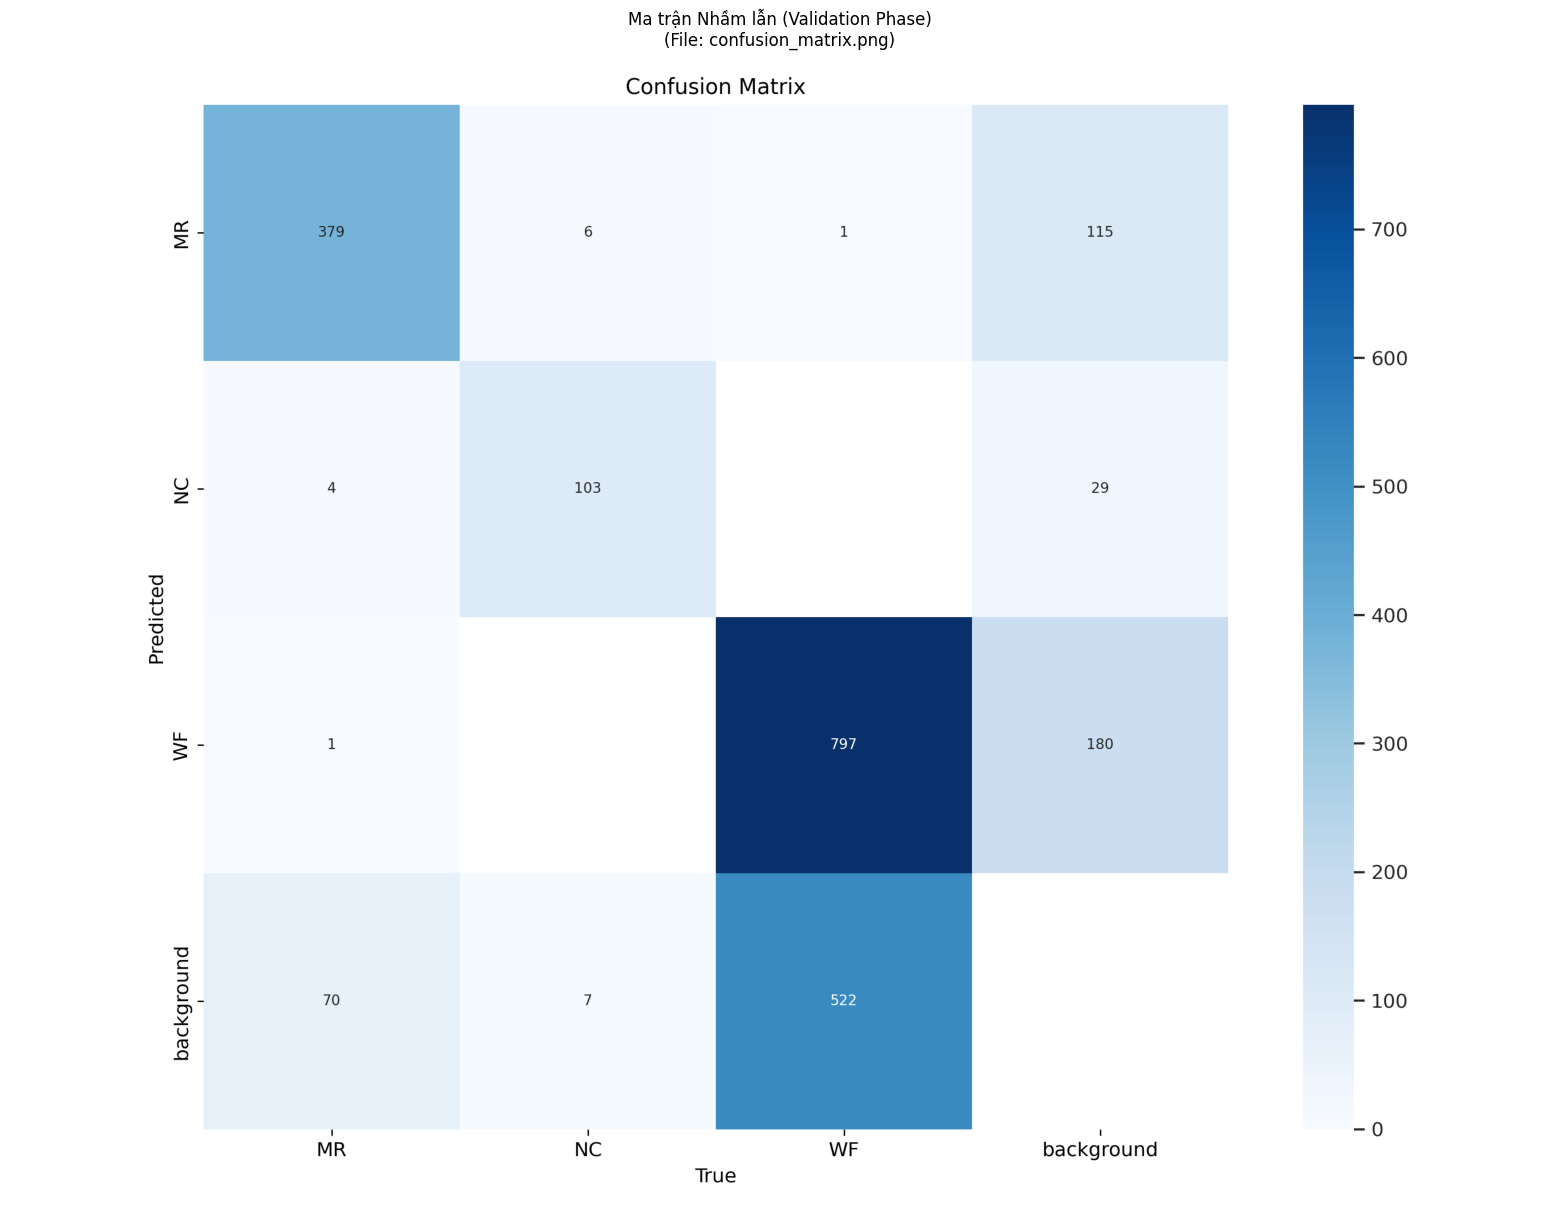

Chú thích: Trục đứng là Lớp Thực tế (Ground Truth), Trục ngang là Lớp Dự đoán (Prediction). Ô (i, j) cho biết số lượng/tỷ lệ mẫu của lớp i bị dự đoán nhầm thành lớp j. Đường chéo chính thể hiện dự đoán đúng. Lý tưởng là các giá trị tập trung trên đường chéo chính.


In [11]:

# Bước 4.3: Ma trận Nhầm lẫn (Validation)

print("\n Bước 4.3: Ma trận Nhầm lẫn (Validation Phase)")

# Biến validation_run_dir cần được lấy từ Cell 4.1
# validation_run_dir = '/kaggle/working/insect_detection_runs_standard/yolov8s_std_e100_img640_b16_validation' # Ví dụ

if 'validation_run_dir' in locals() and validation_run_dir and os.path.exists(validation_run_dir):
    cm_path = os.path.join(validation_run_dir, 'confusion_matrix.png')
    display_plot(cm_path, "Ma trận Nhầm lẫn (Validation Phase)")
    print("Chú thích: Trục đứng là Lớp Thực tế (Ground Truth), Trục ngang là Lớp Dự đoán (Prediction). Ô (i, j) cho biết số lượng/tỷ lệ mẫu của lớp i bị dự đoán nhầm thành lớp j. Đường chéo chính thể hiện dự đoán đúng. Lý tưởng là các giá trị tập trung trên đường chéo chính.")
else:
    print("Không có đường dẫn kết quả validation (validation_run_dir) để hiển thị ma trận nhầm lẫn.")


 Bước 4.4: Đường cong Precision-Recall (Validation Phase) 


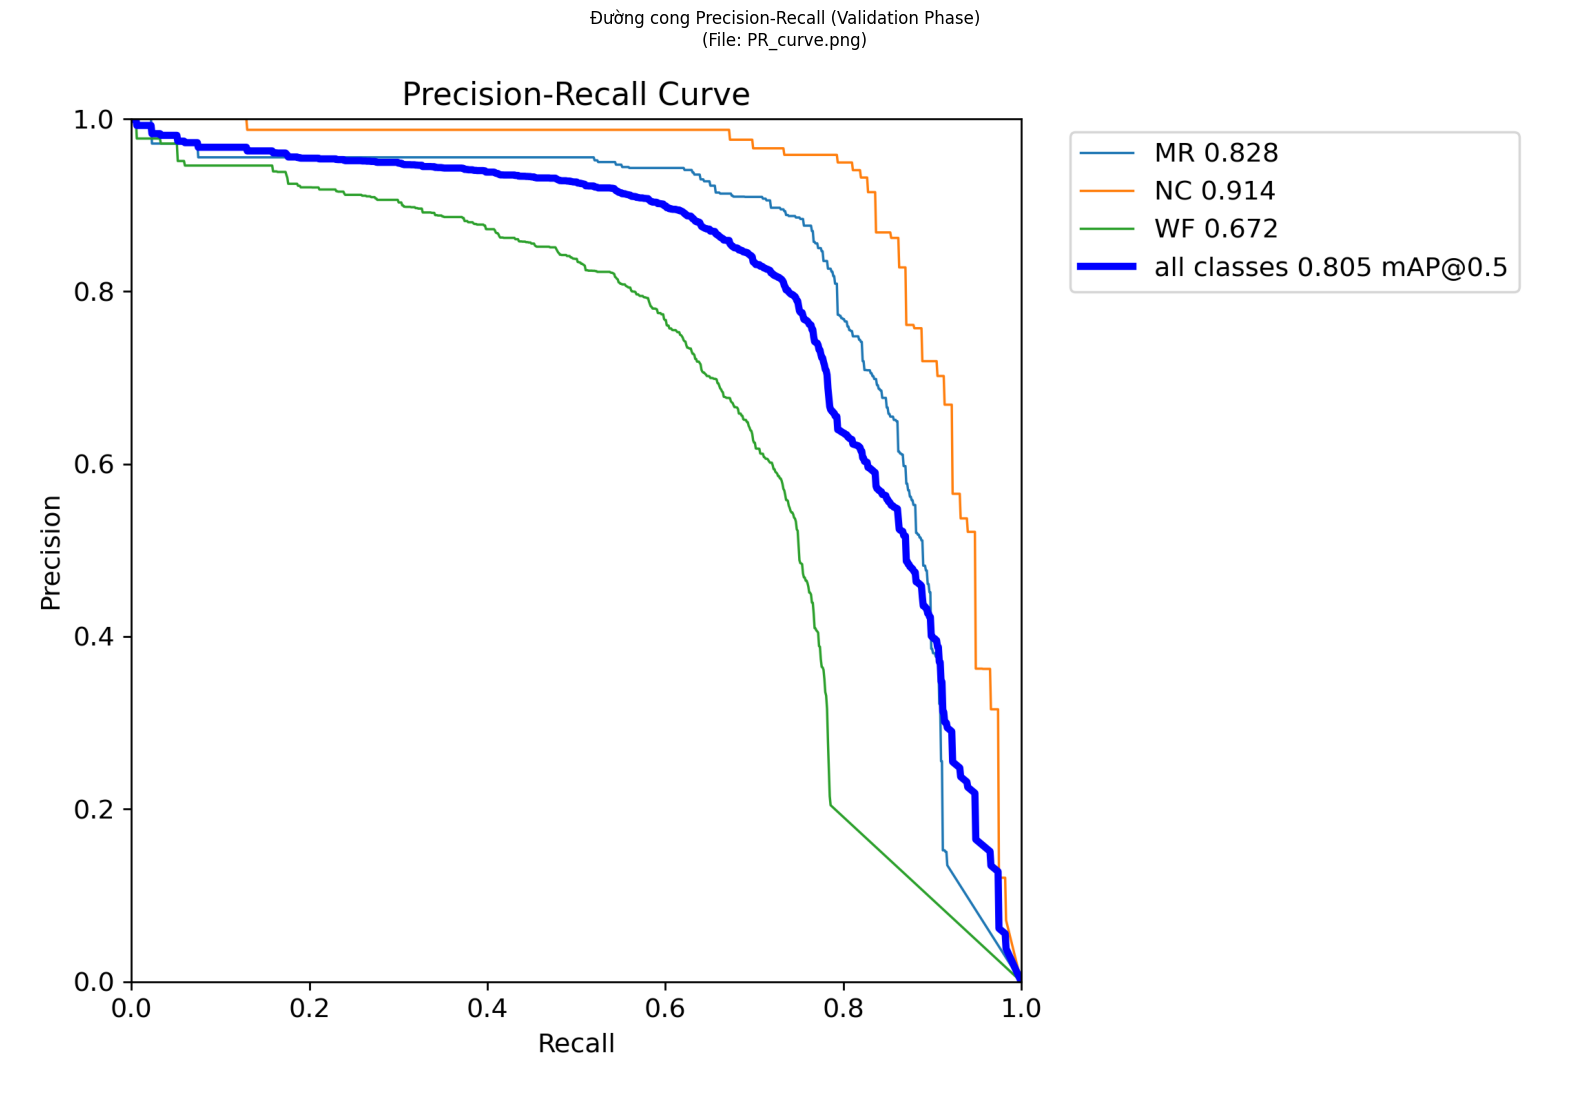

Chú thích: Biểu diễn sự đánh đổi giữa Precision và Recall ở các ngưỡng tin cậy khác nhau. Đường cong càng gần góc trên bên phải càng tốt. Diện tích dưới đường cong này là Average Precision (AP). 'all classes' thể hiện đường trung bình.


In [12]:

# Bước 4.4: Đường cong Precision-Recall (Validation)

print("\n Bước 4.4: Đường cong Precision-Recall (Validation Phase) ")

# Biến validation_run_dir cần được lấy từ Cell 4.1

if 'validation_run_dir' in locals() and validation_run_dir and os.path.exists(validation_run_dir):
    pr_curve_path = os.path.join(validation_run_dir, 'PR_curve.png')
    display_plot(pr_curve_path, "Đường cong Precision-Recall (Validation Phase)")
    print("Chú thích: Biểu diễn sự đánh đổi giữa Precision và Recall ở các ngưỡng tin cậy khác nhau. Đường cong càng gần góc trên bên phải càng tốt. Diện tích dưới đường cong này là Average Precision (AP). 'all classes' thể hiện đường trung bình.")
else:
    print("Không có đường dẫn kết quả validation (validation_run_dir) để hiển thị đường cong PR.")

In [ ]:

# Bước 4.5: Đường cong Precision (Validation)

print("\nBước 4.5: Đường cong Precision (Validation Phase)")

# Biến validation_run_dir cần được lấy từ Cell 4.1

if 'validation_run_dir' in locals() and validation_run_dir and os.path.exists(validation_run_dir):
    p_curve_path = os.path.join(validation_run_dir, 'P_curve.png')
    display_plot(p_curve_path, "Đường cong Precision (Validation Phase)")
    print("Chú thích: Cho thấy Precision thay đổi như thế nào khi thay đổi ngưỡng tin cậy.")
else:
    print("Không có đường dẫn kết quả validation (validation_run_dir) để hiển thị đường cong P.")


--- Bước 4.6: Đường cong Recall (Validation Phase) ---


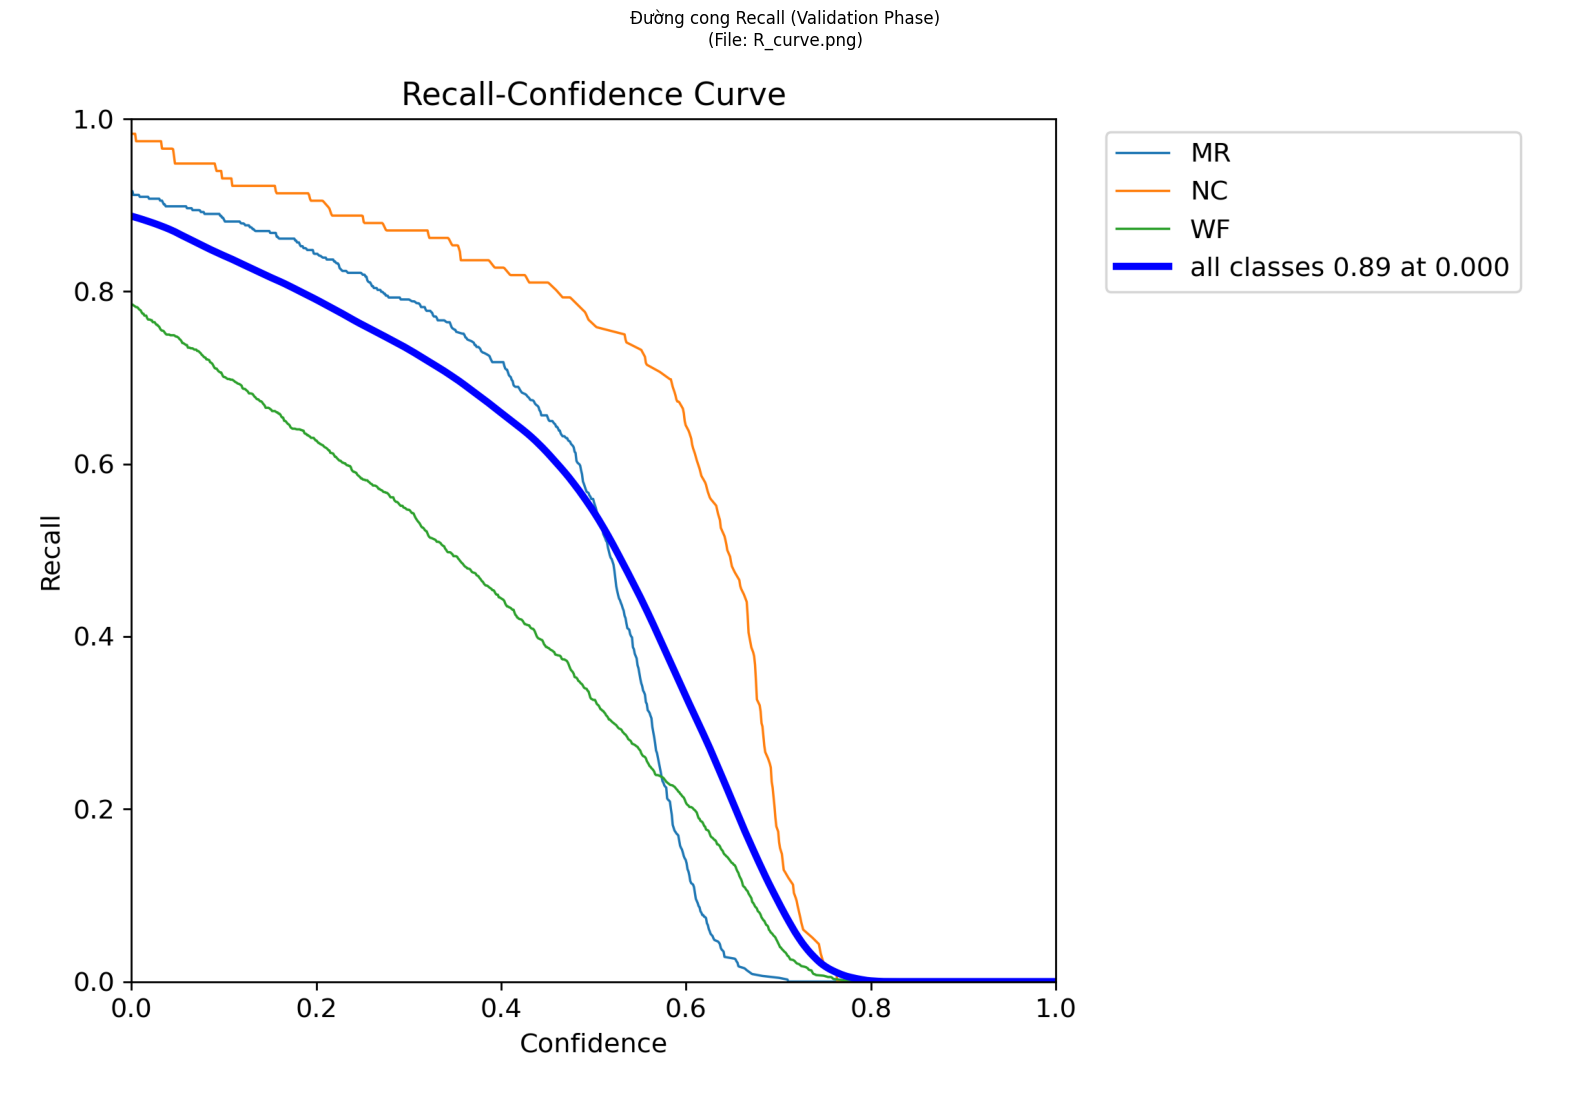

Chú thích: Cho thấy Recall thay đổi như thế nào khi thay đổi ngưỡng tin cậy.


In [13]:

# Bước 4.6: Đường cong Recall (Validation)

print("\n Bước 4.6: Đường cong Recall (Validation Phase)")

# Biến validation_run_dir cần được lấy từ Cell 4.1

if 'validation_run_dir' in locals() and validation_run_dir and os.path.exists(validation_run_dir):
    r_curve_path = os.path.join(validation_run_dir, 'R_curve.png')
    display_plot(r_curve_path, "Đường cong Recall (Validation Phase)")
    print("Chú thích: Cho thấy Recall thay đổi như thế nào khi thay đổi ngưỡng tin cậy.")
else:
    print("Không có đường dẫn kết quả validation (validation_run_dir) để hiển thị đường cong R.")

In [14]:

# Bước 4.7: Phân bố Nhãn (Validation)

print("\n Bước 4.7: Phân bố Nhãn (Validation Phase)")

# Biến validation_run_dir cần được lấy từ Cell 4.1

if 'validation_run_dir' in locals() and validation_run_dir and os.path.exists(validation_run_dir):
    labels_path = os.path.join(validation_run_dir, 'labels.jpg')
    display_plot(labels_path, "Phân bố Nhãn và Bounding Box trong Tập Validation")
    print("Chú thích: Hiển thị số lượng thực thể (instances) của mỗi lớp và phân bố vị trí (tọa độ tâm chuẩn hóa x, y), kích thước (width, height chuẩn hóa) của các bounding box trong tập dữ liệu validation.")
else:
    print("Không có đường dẫn kết quả validation (validation_run_dir) để hiển thị phân bố nhãn.")


 Bước 4.7: Phân bố Nhãn (Validation Phase)
Thông báo: Không tìm thấy file biểu đồ tại: insect_detection_runs_standard/yolov8s_std_e150_img640_b16_validation/labels.jpg
Chú thích: Hiển thị số lượng thực thể (instances) của mỗi lớp và phân bố vị trí (tọa độ tâm chuẩn hóa x, y), kích thước (width, height chuẩn hóa) của các bounding box trong tập dữ liệu validation.


In [15]:

# Bước 4.8: Biểu đồ Tương quan Nhãn (Validation - Optional)

print("\n Bước 4.8: Biểu đồ Tương quan Nhãn (Validation Phase) ")

# Biến validation_run_dir cần được lấy từ Cell 4.1

if 'validation_run_dir' in locals() and validation_run_dir and os.path.exists(validation_run_dir):
    labels_corr_path = os.path.join(validation_run_dir, 'labels_correlogram.jpg')
    # Kiểm tra tồn tại cụ thể cho file này
    if os.path.exists(labels_corr_path):
         display_plot(labels_corr_path, "Biểu đồ Tương quan Nhãn (Validation Phase)")
         print("Chú thích: Thể hiện mối tương quan giữa các đặc điểm của bounding box (tọa độ x, y, width, height) và index của lớp.")
    else:
         print("Thông báo: Không tìm thấy 'labels_correlogram.jpg'. Biểu đồ này có thể không được tạo ở mọi phiên bản/cấu hình.")
else:
    print("Không có đường dẫn kết quả validation (validation_run_dir) để hiển thị tương quan nhãn.")


 Bước 4.8: Biểu đồ Tương quan Nhãn (Validation Phase) 
Thông báo: Không tìm thấy 'labels_correlogram.jpg'. Biểu đồ này có thể không được tạo ở mọi phiên bản/cấu hình.


In [16]:

# Bước 4.9: Đọc Dữ liệu Chi tiết từ results.csv

print("\n Bước 4.9: Đọc dữ liệu chi tiết từ results.csv ")

# Biến TRAIN_OUTPUT_DIR cần được lấy từ Bước 3
# TRAIN_OUTPUT_DIR = '/kaggle/working/insect_detection_runs_standard/yolov8s_std_e100_img640_b16' # Ví dụ

results_csv_path = None
train_df = None

if 'TRAIN_OUTPUT_DIR' in locals() and TRAIN_OUTPUT_DIR and os.path.exists(TRAIN_OUTPUT_DIR):
    results_csv_path = os.path.join(TRAIN_OUTPUT_DIR, 'results.csv')
    if os.path.exists(results_csv_path):
        try:
            # Cần xóa khoảng trắng ở đầu tên cột nếu có
            train_df = pd.read_csv(results_csv_path)
            train_df.columns = train_df.columns.str.strip() # Xóa khoảng trắng thừa
            print(f"Đã đọc thành công dữ liệu từ: {results_csv_path}")
            print("Các cột có sẵn:", list(train_df.columns))
        except Exception as e:
            print(f"Lỗi khi đọc file {results_csv_path}: {e}")
            train_df = None
    else:
        print(f"Lỗi: Không tìm thấy file results.csv tại: {results_csv_path}")
else:
    print("Lỗi: Biến TRAIN_OUTPUT_DIR chưa được định nghĩa hoặc thư mục không tồn tại.")


 Bước 4.9: Đọc dữ liệu chi tiết từ results.csv 
Đã đọc thành công dữ liệu từ: /kaggle/working/insect_detection_runs_standard/yolov8s_std_e150_img640_b16/results.csv
Các cột có sẵn: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']



--- Bước 4.10: Biểu đồ Train Losses (Y-axis: 0-1) ---


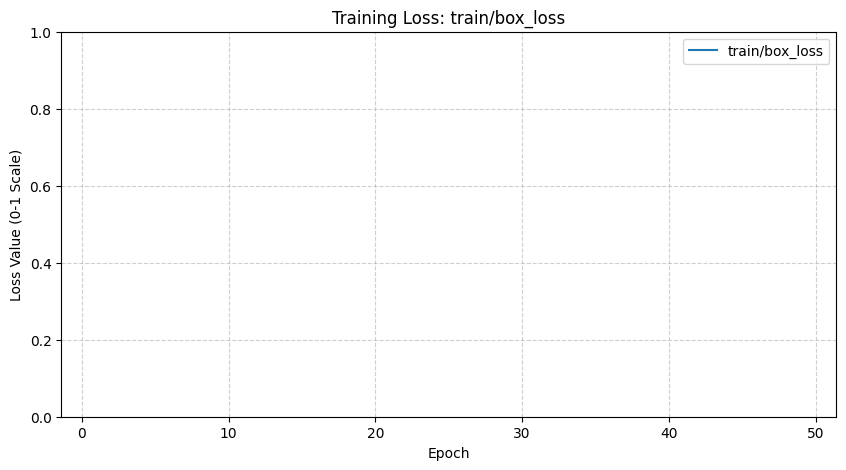

Chú thích train/box_loss: Giá trị loss của thành phần tương ứng (bounding box, phân loại, distribution focal loss) trên tập huấn luyện qua các epoch. Lý tưởng là giá trị này giảm dần về 0. Trục Y được giới hạn từ 0-1 để dễ so sánh xu hướng, giá trị loss ban đầu có thể lớn hơn 1.


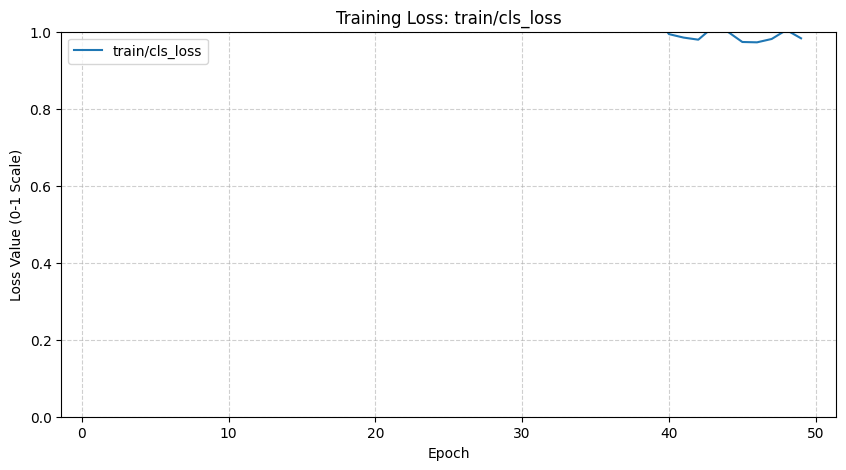

Chú thích train/cls_loss: Giá trị loss của thành phần tương ứng (bounding box, phân loại, distribution focal loss) trên tập huấn luyện qua các epoch. Lý tưởng là giá trị này giảm dần về 0. Trục Y được giới hạn từ 0-1 để dễ so sánh xu hướng, giá trị loss ban đầu có thể lớn hơn 1.


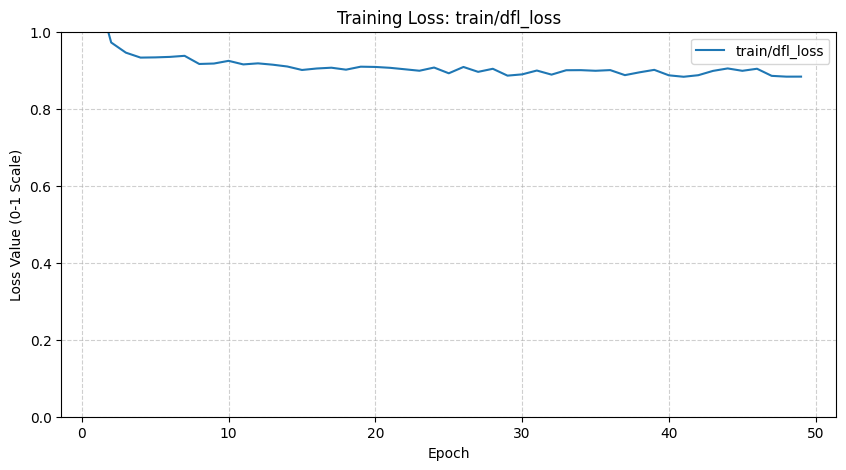

Chú thích train/dfl_loss: Giá trị loss của thành phần tương ứng (bounding box, phân loại, distribution focal loss) trên tập huấn luyện qua các epoch. Lý tưởng là giá trị này giảm dần về 0. Trục Y được giới hạn từ 0-1 để dễ so sánh xu hướng, giá trị loss ban đầu có thể lớn hơn 1.


In [17]:

# Bước 4.10: Biểu đồ Train Losses

print("\n--- Bước 4.10: Biểu đồ Train Losses (Y-axis: 0-1) ---")

if train_df is not None:
    loss_cols = ['train/box_loss', 'train/cls_loss', 'train/dfl_loss']
    for col in loss_cols:
        if col in train_df.columns:
            plt.figure(figsize=(10, 5)) # Kích thước nhỏ hơn cho plot đơn
            plt.plot(train_df['epoch'], train_df[col], label=col)
            plt.ylim(0, 1) # Set Y-axis từ 0 đến 1
            plt.xlabel("Epoch")
            plt.ylabel("Loss Value (0-1 Scale)")
            plt.title(f"Training Loss: {col}")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()
            print(f"Chú thích {col}: Giá trị loss của thành phần tương ứng (bounding box, phân loại, distribution focal loss) trên tập huấn luyện qua các epoch. Lý tưởng là giá trị này giảm dần về 0. Trục Y được giới hạn từ 0-1 để dễ so sánh xu hướng, giá trị loss ban đầu có thể lớn hơn 1.")
        else:
            print(f"Thông báo: Không tìm thấy cột '{col}' trong results.csv.")
else:
    print("Không có dữ liệu huấn luyện (train_df) để vẽ biểu đồ loss.")

In [ ]:

# Bước 4.11: Biểu đồ Validation Losses

print("\n Bước 4.11: Biểu đồ Validation Losses (Y-axis: 0-1) ")

if train_df is not None:
    loss_cols = ['val/box_loss', 'val/cls_loss', 'val/dfl_loss']
    for col in loss_cols:
        if col in train_df.columns:
            plt.figure(figsize=(10, 5))
            plt.plot(train_df['epoch'], train_df[col], label=col, color='orange') # Màu khác cho validation
            plt.ylim(0, 1) # Set Y-axis từ 0 đến 1
            plt.xlabel("Epoch")
            plt.ylabel("Loss Value (0-1 Scale)")
            plt.title(f"Validation Loss: {col}")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()
            print(f"Chú thích {col}: Giá trị loss tương ứng trên tập validation. So sánh với train loss giúp phát hiện overfitting (nếu val loss bắt đầu tăng trong khi train loss vẫn giảm). Trục Y giới hạn 0-1.")
        else:
            print(f"Thông báo: Không tìm thấy cột '{col}' trong results.csv.")
else:
    print("Không có dữ liệu huấn luyện (train_df) để vẽ biểu đồ loss.")


--- Bước 4.12: Biểu đồ Metrics - Precision & Recall (Y-axis: 0-1) ---


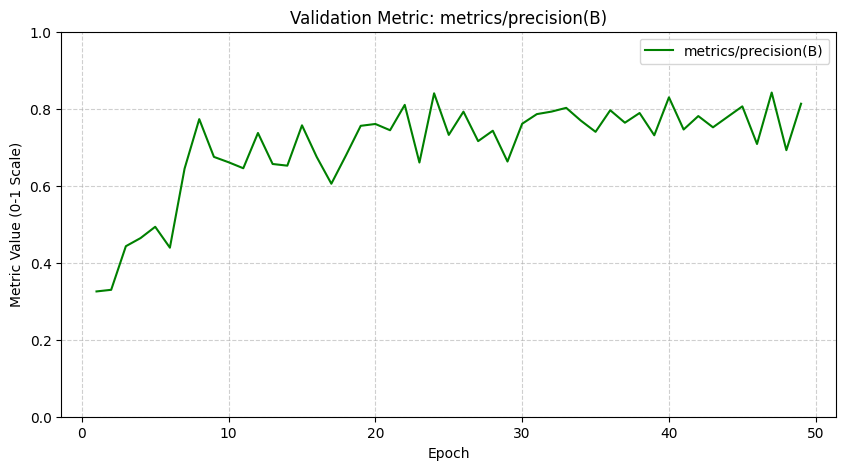

Chú thích metrics/precision(B): Giá trị metric tương ứng (Precision hoặc Recall) được tính trên tập validation qua các epoch. Lý tưởng là các giá trị này tăng dần về 1.


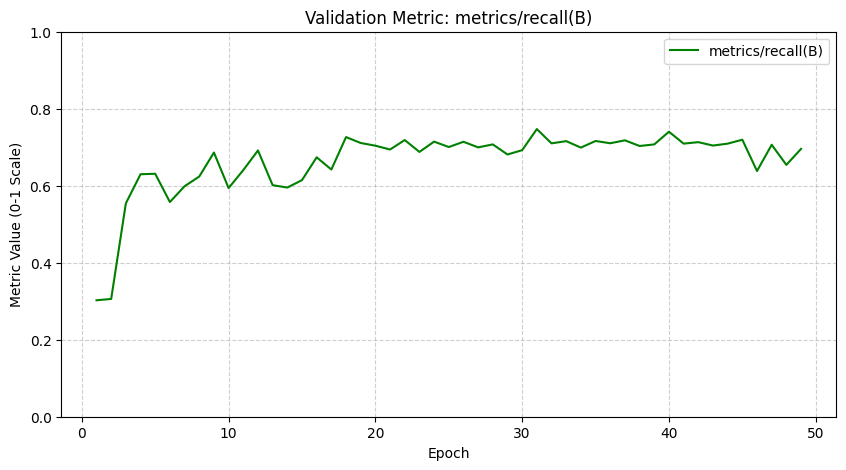

Chú thích metrics/recall(B): Giá trị metric tương ứng (Precision hoặc Recall) được tính trên tập validation qua các epoch. Lý tưởng là các giá trị này tăng dần về 1.


In [18]:

# Bước 4.12: Biểu đồ Metrics (Precision, Recall)

print("\n--- Bước 4.12: Biểu đồ Metrics - Precision & Recall (Y-axis: 0-1) ---")

if train_df is not None:
    # Tên cột có thể thay đổi nhẹ, ví dụ 'metrics/precision(B)' hoặc chỉ 'metrics/precision'
    metric_cols = ['metrics/precision(B)', 'metrics/recall(B)']
    # Thử các tên thay thế nếu tên gốc không có
    if 'metrics/precision(B)' not in train_df.columns and 'metrics/precision' in train_df.columns:
        metric_cols[0] = 'metrics/precision'
    if 'metrics/recall(B)' not in train_df.columns and 'metrics/recall' in train_df.columns:
         metric_cols[1] = 'metrics/recall'

    for col in metric_cols:
        if col in train_df.columns:
            plt.figure(figsize=(10, 5))
            plt.plot(train_df['epoch'], train_df[col], label=col, color='green') # Màu khác cho metrics
            plt.ylim(0, 1) # Set Y-axis từ 0 đến 1
            plt.xlabel("Epoch")
            plt.ylabel("Metric Value (0-1 Scale)")
            plt.title(f"Validation Metric: {col}")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()
            print(f"Chú thích {col}: Giá trị metric tương ứng (Precision hoặc Recall) được tính trên tập validation qua các epoch. Lý tưởng là các giá trị này tăng dần về 1.")
        else:
            print(f"Thông báo: Không tìm thấy cột metric '{col}' (hoặc tên thay thế) trong results.csv.")
else:
    print("Không có dữ liệu huấn luyện (train_df) để vẽ biểu đồ metrics.")


--- Bước 4.13: Biểu đồ Metrics - mAP (Y-axis: 0-1) ---


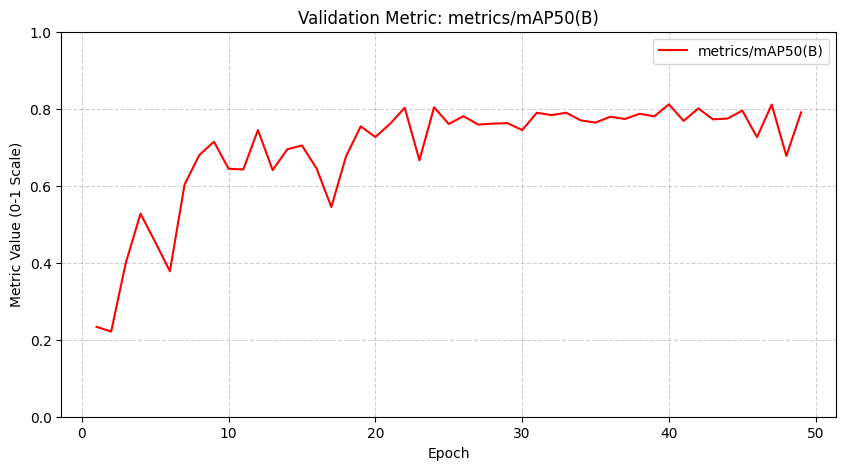

Chú thích metrics/mAP50(B): Giá trị metric mAP tương ứng được tính trên tập validation qua các epoch. Lý tưởng là các giá trị này tăng dần về 1.


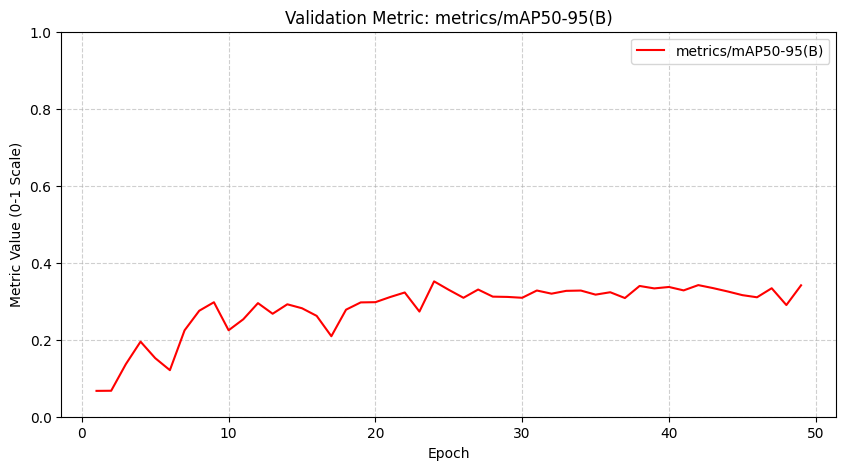

Chú thích metrics/mAP50-95(B): Giá trị metric mAP tương ứng được tính trên tập validation qua các epoch. Lý tưởng là các giá trị này tăng dần về 1.


In [19]:

# Bước 4.13: Biểu đồ Metrics (mAP50, mAP50-95)

print("\n--- Bước 4.13: Biểu đồ Metrics - mAP (Y-axis: 0-1) ---")

if train_df is not None:
    # Tên cột có thể thay đổi nhẹ, ví dụ 'metrics/mAP50(B)' hoặc 'metrics/mAP_0.5'
    metric_cols = ['metrics/mAP50(B)', 'metrics/mAP50-95(B)']
    # Thử các tên thay thế
    if 'metrics/mAP50(B)' not in train_df.columns and 'metrics/mAP_0.5' in train_df.columns:
        metric_cols[0] = 'metrics/mAP_0.5'
    if 'metrics/mAP50-95(B)' not in train_df.columns and 'metrics/mAP_0.5:0.95' in train_df.columns:
         metric_cols[1] = 'metrics/mAP_0.5:0.95'

    for col in metric_cols:
        if col in train_df.columns:
            plt.figure(figsize=(10, 5))
            plt.plot(train_df['epoch'], train_df[col], label=col, color='red') # Màu khác cho mAP
            plt.ylim(0, 1) # Set Y-axis từ 0 đến 1
            plt.xlabel("Epoch")
            plt.ylabel("Metric Value (0-1 Scale)")
            plt.title(f"Validation Metric: {col}")
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()
            print(f"Chú thích {col}: Giá trị metric mAP tương ứng được tính trên tập validation qua các epoch. Lý tưởng là các giá trị này tăng dần về 1.")
        else:
            print(f"Thông báo: Không tìm thấy cột mAP '{col}' (hoặc tên thay thế) trong results.csv.")
else:
    print("Không có dữ liệu huấn luyện (train_df) để vẽ biểu đồ metrics.")


--- Bước 5: Sử dụng Mô hình (Inference) ---
Tải model: /kaggle/working/insect_detection_runs_standard/yolov8s_std_e150_img640_b16/weights/best.pt

Chọn 10 ảnh đầu tiên từ tập validation cuối cùng để dự đoán...
Kết quả inference sẽ lưu trong: insect_detection_runs_standard/yolov8s_std_e150_img640_b16_inference_results

0: 448x640 3 MRs, 38 WFs, 9.0ms
1: 448x640 5 MRs, 33 WFs, 9.0ms
2: 448x640 23 WFs, 9.0ms
3: 448x640 23 WFs, 9.0ms
4: 448x640 6 MRs, 1 NC, 9.0ms
5: 448x640 9 MRs, 9.0ms
6: 448x640 6 MRs, 9.0ms
7: 448x640 7 MRs, 9.0ms
8: 448x640 19 NCs, 9.0ms
9: 448x640 5 NCs, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
Results saved to insect_detection_runs_standard/yolov8s_std_e150_img640_b16_inference_results

Hiển thị 10 ảnh kết quả dự đoán (lưu tại /kaggle/working/insect_detection_runs_standard/yolov8s_std_e150_img640_b16_inference_results):


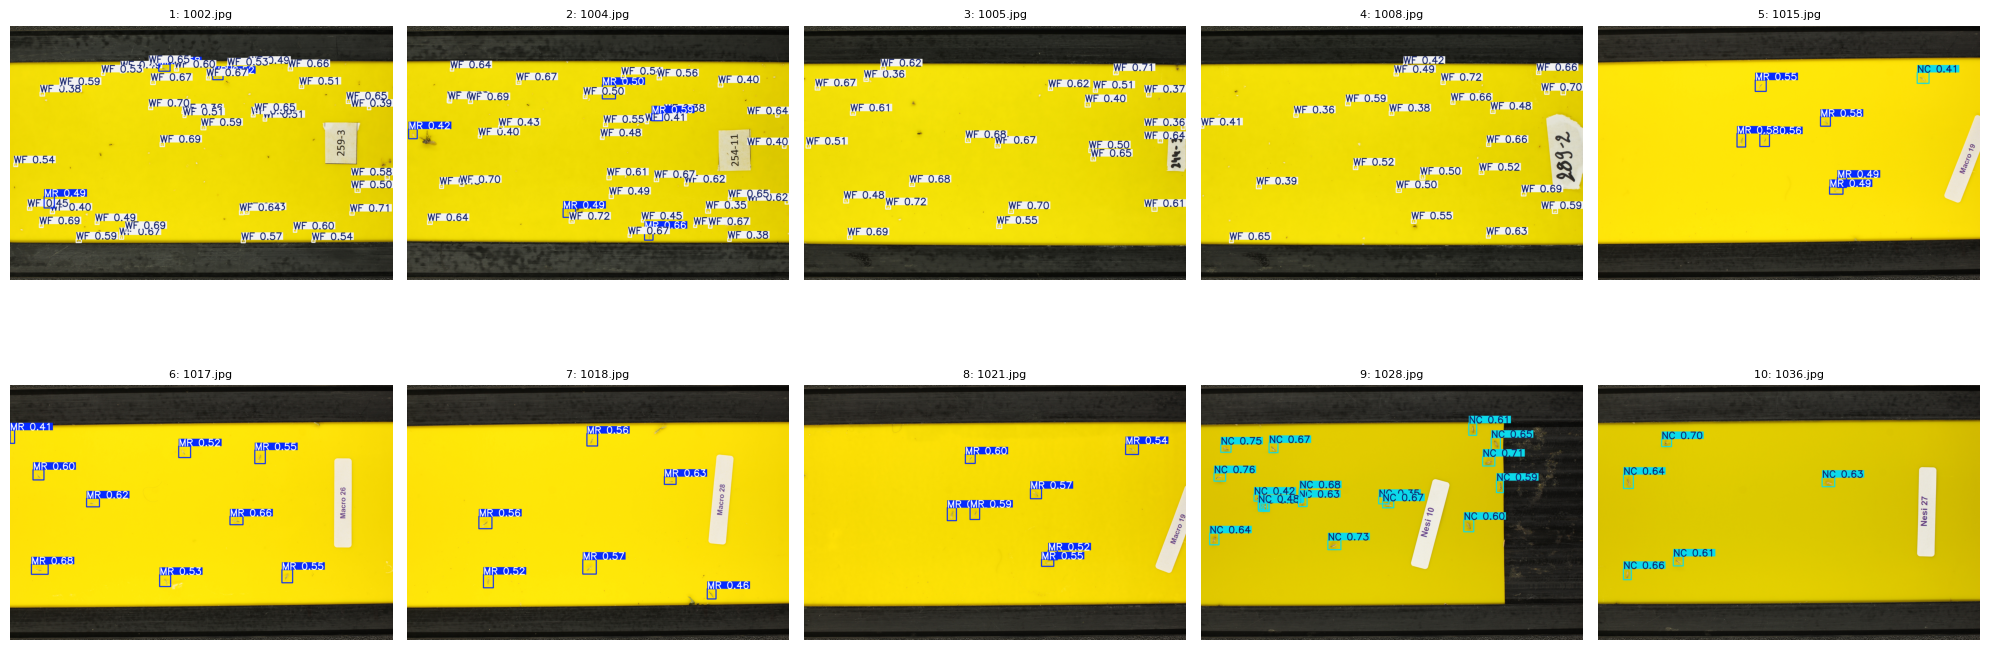


--- HOÀN THÀNH TẤT CẢ CÁC BƯỚC ---


In [20]:


# Bước 5: Sử dụng Mô hình (Inference)

print("\n--- Bước 5: Sử dụng Mô hình (Inference) ---")
if BEST_MODEL_PATH:
    print(f"Tải model: {BEST_MODEL_PATH}")
    try:
        inference_model = YOLO(BEST_MODEL_PATH)
        # Lấy danh sách ảnh trong tập validation CUỐI CÙNG (ảnh gốc)
        val_image_dir_final = final_val_img_dir
        val_image_files_final = sorted(glob.glob(os.path.join(val_image_dir_final, '*.jpg')) + \
                                       glob.glob(os.path.join(val_image_dir_final, '*.png')))

        num_images_to_show = 10 # Hiển thị 10 ảnh theo yêu cầu
        if len(val_image_files_final) > 0:
            if len(val_image_files_final) > num_images_to_show:
                 # test_images = random.sample(val_image_files_final, k=num_images_to_show) # Ngẫu nhiên
                 test_images = val_image_files_final[:num_images_to_show] # Lấy 10 ảnh đầu
                 print(f"\nChọn {num_images_to_show} ảnh đầu tiên từ tập validation cuối cùng để dự đoán...")
            else:
                 test_images = val_image_files_final
                 num_images_to_show = len(test_images) # Cập nhật lại số lượng nếu ít hơn 10
                 print(f"\nChạy dự đoán trên tất cả {len(test_images)} ảnh validation cuối cùng...")

            inference_results_dir_name = f'{RUN_NAME}_inference_results'
            print(f"Kết quả inference sẽ lưu trong: {PROJECT_NAME}/{inference_results_dir_name}")

            results_list = inference_model.predict(
                                          source=test_images,
                                          imgsz=IMG_SIZE, # Kích thước ảnh đầu vào cho inference
                                          conf=0.35,      # Ngưỡng tin cậy
                                          save=True,      # Lưu ảnh kết quả
                                          project=PROJECT_NAME,
                                          name=inference_results_dir_name,
                                          exist_ok=True,
                                          device=0
                                          )

            # Hiển thị kết quả
            predict_save_dir = os.path.join('/kaggle/working', PROJECT_NAME, inference_results_dir_name)
            print(f"\nHiển thị {num_images_to_show} ảnh kết quả dự đoán (lưu tại {predict_save_dir}):")
            predicted_image_files = sorted(glob.glob(os.path.join(predict_save_dir, '*.jpg')) + \
                                           glob.glob(os.path.join(predict_save_dir, '*.png')))

            if predicted_image_files:
        
                predicted_image_files = predicted_image_files[:num_images_to_show]

                cols = 5 # Điều chỉnh số cột hiển thị
                rows = int(np.ceil(len(predicted_image_files) / cols))
                plt.figure(figsize=(4 * cols, 4 * rows + 1)) # Điều chỉnh kích thước

                for i, img_path in enumerate(predicted_image_files):
                    img = cv2.imread(img_path)
                    if img is not None:
                        # Đảm bảo subplot index hợp lệ
                         if i < rows * cols:
                             plt.subplot(rows, cols, i + 1)
                             plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                             plt.title(f"{i+1}: {os.path.basename(img_path)}", fontsize=8)
                             plt.axis('off')
                    else:
                         print(f" Lỗi đọc ảnh kết quả: {img_path}")


                plt.tight_layout(rect=[0, 0.03, 1, 0.98])
                plt.show()
            else: print(f"Không tìm thấy file ảnh kết quả dự đoán đã lưu.")
        else: print("Không tìm thấy ảnh nào trong thư mục validation cuối cùng.")
    except Exception as e:
        print(f"Lỗi Inference: {e}")
        import traceback; traceback.print_exc()
else:
    print("Không thể chạy Inference do không có model tốt nhất.")


print("\n--- HOÀN THÀNH TẤT CẢ CÁC BƯỚC ---")